In [ ]:
#Adapted from DeepLabv3FineTuning

In [3]:
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd

In [4]:
# Load the trained model 
model = torch.load('./SpringsModelE4B4/weights.pt')
# Set the model to evaluate mode
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [5]:
# Read the log file using pandas into a dataframe
df = pd.read_csv('./SpringsModelE4B4/log.csv')

### Training and testing loss, f1_score and auroc values for the model trained on the CrackForest dataset

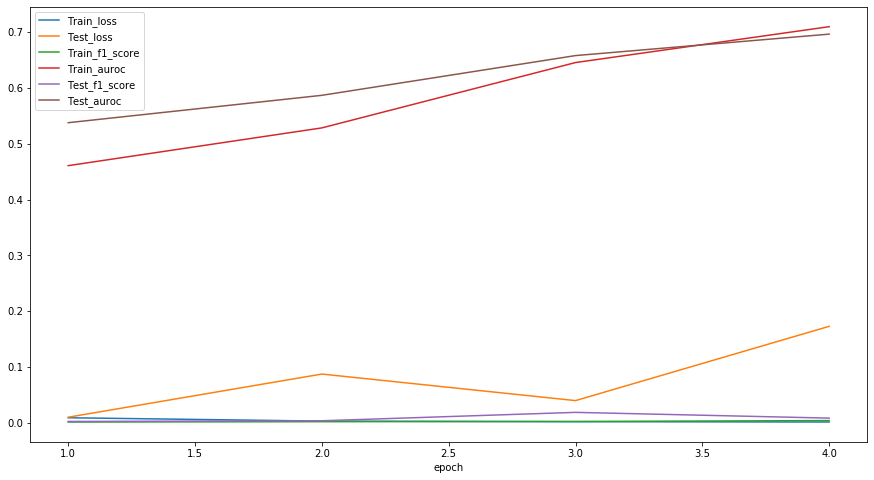

In [6]:
# Plot all the values with respect to the epochs
df.plot(x='epoch',figsize=(15,8));

In [7]:
print(df[['Train_auroc','Test_auroc']])

   Train_auroc  Test_auroc
0     0.460648    0.537599
1     0.528284    0.586638
2     0.645331    0.657816
3     0.709586    0.696251


In [8]:
print(df[['Train_f1_score','Test_f1_score']])

   Train_f1_score  Test_f1_score
0        0.001348       0.002399
1        0.001956       0.003609
2        0.002337       0.018661
3        0.003968       0.008383


In [9]:
print(df[['Train_loss','Test_loss']])

   Train_loss  Test_loss
0    0.009014   0.009987
1    0.003021   0.087293
2    0.001985   0.039747
3    0.001388   0.172798


### Sample Prediction

In [30]:
# Read  a sample image and mask from the data-set
img = cv2.imread(f'./Spring/Synthetic Images/1/normal/render_6.png').transpose(2,0,1).reshape(1,3,768,1024)
mask = cv2.imread(f'./Spring/Synthetic Images/1/mask/render_6.png')
with torch.no_grad():
    a = model(torch.from_numpy(img).type(torch.FloatTensor)/255)

(array([2.58000e+02, 6.38200e+03, 4.83800e+04, 1.49112e+05, 2.28569e+05,
        1.87593e+05, 1.27082e+05, 3.45110e+04, 4.41900e+03, 1.26000e+02]),
 array([-0.07527323, -0.06471536, -0.05415748, -0.04359961, -0.03304174,
        -0.02248386, -0.01192599, -0.00136812,  0.00918975,  0.01974763,
         0.0303055 ], dtype=float32),
 <a list of 10 Patch objects>)

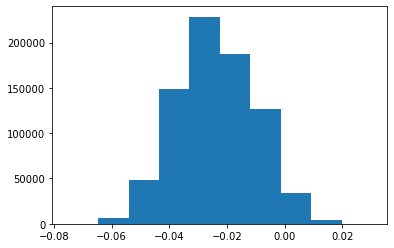

In [31]:
# Plot histogram of the prediction to find a suitable threshold. From the histogram a 0.1 looks like a good choice.
plt.hist(a['out'].data.cpu().numpy().flatten())

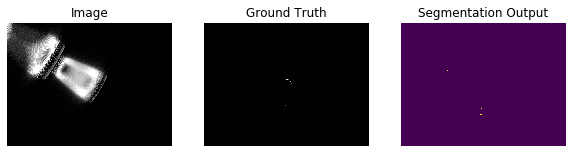

In [34]:
# Plot the input image, ground truth and the predicted output
plt.figure(figsize=(10,10));
plt.subplot(131);
plt.imshow(img[0,...].transpose(1,2,0));
plt.title('Image')
plt.axis('off');
plt.subplot(132);
plt.imshow(mask);
plt.title('Ground Truth')
plt.axis('off');
plt.subplot(133);
plt.imshow(a['out'].cpu().detach().numpy()[0][0]>0.02);
plt.title('Segmentation Output')
plt.axis('off');
plt.savefig('./CFExp/SegmentationOutput.png',bbox_inches='tight')

In [43]:
from tensorflow.keras import backend as K
import numpy as np

In [59]:
#output = a['out'].cpu().detach().numpy()[0][0]>0.15
#output = np.array(output, dtype=np.int8)

output = np.where(a['out']>0.16,255,0)

#print(output)
#print(mask)
#output = cv2.cvtColor(output,cv2.COLOR_GRAY2RGB)
img2 = np.zeros_like(mask)
img2[:,:,0] = output
img2[:,:,1] = output
img2[:,:,2] = output
output=img2
#y_true = np.array(mask, dtype=np.int8)
#y_pred = output
#print(y_true.shape)
#print(y_pred.shape)
cv2.imwrite(f'./prediction/render_1 (2).16.png',output)

True

In [62]:

y_true= np.array(mask, dtype=np.int8)
y_pred= np.array(cv2.imread(f'./prediction/render_1 (2).16.png'), dtype=np.int8)
smooth=1
intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
iou = K.mean((intersection + smooth) / (union + smooth), axis=0)

print(iou)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


InvalidArgumentError: Invalid reduction dimension (3 for input with 3 dimension(s) [Op:Sum]